In [12]:
from sklearn.datasets import fetch_rcv1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [13]:
X, y = fetch_rcv1(shuffle=True, return_X_y=True)

In [48]:
class SOM:
    def __init__(self, map_size, lr=0.1):
        """
        :param map_size: [map_w, map_h, f]
        """
        self.map = np.random.random(size=map_size)
        self.lr0 = lr
        self.lr = lr
        
        self.R0 = map_size[0]//2
        self.R = self.R0

        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 3))
    
    def find_winner(self, x):
        repeated_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - repeated_x)**2, axis=2)
        
        winner = np.unravel_index(np.argmin(dists), dists.shape)
        
        return winner
    
    def get_NS(self, winner):
        NS = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))

        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1
        
        for r in range(1, int(self.R)):
            if iw - r >= 0:
                NS[iw - r, jw] = 1/r   
            if iw + r < self.map.shape[0]:
                NS[iw + r, jw] = 1/r
                
            if jw - r >= 0:
                NS[iw, jw - r] = 1/r
            if jw + r < self.map.shape[1]:
                NS[iw, jw + r] = 1/r
                
        return NS
        
    
    def update_weights(self, x, n_strength):
        NS = np.tile(n_strength, [self.map.shape[2], 1, 1]).transpose() # ERROR
        
        repeated_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        Delta = repeated_x - self.map
        
        self.map += self.lr * np.multiply(NS, Delta)
    
    def train(self, X, epochs=1000, error_threshold=10**-20):
        Js = []
        for epoch in range(epochs):
            prev_map = np.copy(self.map)
            for row in range(X.shape[0]):
                x = X[row, :]
                x = x.toarray()
                winner = self.find_winner(x) # winner = [5, 23]
                neighbors = self.get_NS(winner)
                self.update_weights(x, neighbors)
            
            self.lr = self.lr0 * (1 - epoch/epochs)
            self.R = self.R0 * (1 - epoch/epochs)
            
            Js.append(np.linalg.norm(prev_map - self.map))
            
#             if epoch % 100 == 0:
            print("Iteration: %d, LR: %f, R: %f, J: %f" %(epoch, self.lr, self.R, Js[-1]))
            
            if Js[-1] < error_threshold:
                print("MIN CHANGE")
                break
            
        return Js

    def visualize(self, X, y):
        for i, (x, label) in enumerate(zip(X, y)):
            x = x.toarray()
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            # c = np.unravel_index(np.argmax(label), label.shape)[1]

            self.scores[iw, jw] += np.asarray([label[0], label[1], label[2]])

            # if c < 34:
            #     self.scores[iw, jw] += np.asarray([1, 0, 0])
            # if 34 <= c < 68:
            #     self.scores[iw, jw] += np.asarray([0, 0, 1])
            # if 68 <= c:
            #     self.scores[iw, jw] += np.asarray([0, 1, 0])

        for i in range(self.map.shape[0]):
            for j in range(self.map.shape[1]):
                norm = np.linalg.norm(self.scores[i, j])
                self.scores[i, j] = self.scores[i, j] * 255 /norm

        plt.imshow(self.scores)
        plt.show()

    def visualize2(self, X, y):
        for i, (x, label) in enumerate(zip(X, y)):
            x = x.toarray()
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            # c = np.unravel_index(np.argmax(label), label.shape)[1]

            if label == 1:
                self.scores[iw, jw] += np.asarray([1, 0, 0])
            else:
                self.scores[iw, jw] += np.asarray([0, 0, 1])

        for i in range(self.map.shape[0]):
            for j in range(self.map.shape[1]):
                norm = np.linalg.norm(self.scores[i, j])
                self.scores[i, j] = self.scores[i, j] * 255 /norm

        plt.imshow(self.scores)
        plt.show()

    def purity(self, X, y):
        map = np.zeros((9, 9, 103))
        for i, (x, label) in enumerate(zip(X, y)):
            x = x.toarray()
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            c = np.unravel_index(np.argmax(label), label.shape)[1]
            map[iw, jw, c] += 1

        sigma = 0
        for i in range(9):
            for j in range(9):
                sigma += np.unravel_index(np.argmax(map[i, j]), map[i, j].shape)[1]

        p = sigma/X.shape[0]
        return p

In [49]:
X_small, y_small = X[:100], y[:100]

In [50]:
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
y_new = svd.fit_transform(y_small)
# print(svd.explained_variance_ratio_)
# print(svd.explained_variance_ratio_.sum())
# print(svd.singular_values_)

In [51]:
som_net = SOM(map_size=[20, 20, X_small.shape[1]])
Js = som_net.train(X_small, epochs=3)

Iteration: 0, LR: 0.100000, R: 10.000000, J: 674.392683
Iteration: 1, LR: 0.066667, R: 6.666667, J: 418.903779
Iteration: 2, LR: 0.033333, R: 3.333333, J: 195.754408


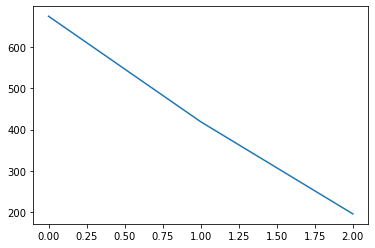

In [52]:
plt.plot(Js)
plt.show()

<ipython-input-48-1cffe6e2281b>:96: RuntimeWarning: invalid value encountered in true_divide
  self.scores[i, j] = self.scores[i, j] * 255 /norm
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


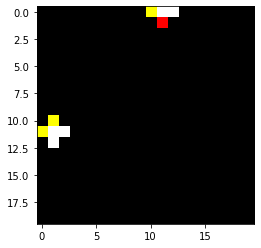

In [53]:
som_net.visualize(X_small, y_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


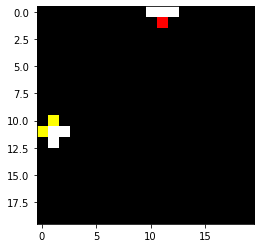

In [54]:
som_net.visualize2(X_small, y_small[:, 0])

In [7]:
som_net.purity(X_small, y_small)


(804414, 103)